In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cross_sect = pd.read_csv('https://raw.githubusercontent.com/ChacoGolden/Stat-Data-Science/refs/heads/main/cross_sect_inc_waste_kg.csv')
education_data = pd.read_csv('https://raw.githubusercontent.com/ChacoGolden/Stat-Data-Science/refs/heads/main/average_education.csv')

In [3]:
print(cross_sect['Country'].nunique())
print(education_data['Country'].nunique())

26
32


In [4]:
# Get sets of countries in each dataset
countries_cross_sect = set(cross_sect['Country'])
countries_education = set(education_data['Country'])

# Countries present in cross_sect but not in education_data
missing_in_education = countries_cross_sect - countries_education
print("\nCountries in cross_sect but not in education_data:")
print(missing_in_education)

# Countries present in education_data but not in cross_sect
missing_in_cross_sect = countries_education - countries_cross_sect
print("\nCountries in education_data but not in cross_sect:")
print(missing_in_cross_sect)



Countries in cross_sect but not in education_data:
set()

Countries in education_data but not in cross_sect:
{'Iceland', 'Netherlands', 'Croatia', 'Greece', 'Serbia', 'Switzerland'}


In [5]:
# Countries present in both datasets
common_countries = countries_cross_sect & countries_education
print("\nCommon countries in both datasets:")
print(common_countries)


Common countries in both datasets:
{'Malta', 'Hungary', 'Bulgaria', 'Estonia', 'Poland', 'Sweden', 'Germany', 'Slovakia', 'Italy', 'Denmark', 'Czechia', 'Austria', 'Belgium', 'Cyprus', 'Ireland', 'Romania', 'Latvia', 'Portugal', 'Lithuania', 'Spain', 'France', 'Türkiye', 'Luxembourg', 'Finland', 'Slovenia', 'Norway'}


In [6]:
# Perform a left join to merge the education_data into cross_sect
merged_data = pd.merge(cross_sect, education_data, on='Country', how='left')

# Display the merged dataset
print("\nMerged Dataset:")
print(merged_data.head())

# Check for missing values in the education columns (countries not in education_data will have NaNs)
missing_education_data = merged_data[merged_data.isnull().any(axis=1)]
print("\nCountries with missing education data after merging:")
print(missing_education_data[['Country']])



Merged Dataset:
    Country  Income Average  Waste Average  Average_Education_Level
0   Belgium         24451.9     447.059027                    36.27
1  Bulgaria          4286.8     400.376196                    25.10
2   Czechia          9730.2     443.899034                    21.67
3   Denmark         30502.6     607.350966                    32.79
4   Germany         23197.7     452.967933                    25.95

Countries with missing education data after merging:
Empty DataFrame
Columns: [Country]
Index: []


In [7]:
# Define dependent (Y) and independent variables (X)
Y = merged_data['Waste Average']  # Dependent variable
X = merged_data[['Income Average', 'Average_Education_Level']]  # Independent variables

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(Y, X).fit()

# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Waste Average   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     2.285
Date:                Tue, 26 Nov 2024   Prob (F-statistic):              0.124
Time:                        14:48:28   Log-Likelihood:                -148.27
No. Observations:                  26   AIC:                             302.5
Df Residuals:                      23   BIC:                             306.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Define the predictors (independent variables)
X_vif = sm.add_constant(merged_data[['Income Average', 'Average_Education_Level']])  # Include a constant for regression

# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data['Feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# Display the VIF values
print("\nVariance Inflation Factor (VIF):")
print(vif_data)



Variance Inflation Factor (VIF):
                   Feature        VIF
0                    const  18.325408
1           Income Average   1.706805
2  Average_Education_Level   1.706805


In [9]:
# Add interaction term: Income Average * Average Education Level
merged_data['interaction'] = merged_data['Income Average'] * merged_data['Average_Education_Level']

# Define dependent (Y) and independent variables (X)
Y = merged_data['Waste Average']  # Dependent variable
X = merged_data[['Income Average', 'Average_Education_Level', 'interaction']]  # Include interaction term

# Add a constant to the model (intercept)
X = sm.add_constant(X)


In [10]:
# Fit the regression model with the interaction term
refined_model = sm.OLS(Y, X).fit()

# Print the summary of the refined regression model
print(refined_model.summary())


                            OLS Regression Results                            
Dep. Variable:          Waste Average   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     6.144
Date:                Tue, 26 Nov 2024   Prob (F-statistic):            0.00339
Time:                        14:48:28   Log-Likelihood:                -142.72
No. Observations:                  26   AIC:                             293.4
Df Residuals:                      22   BIC:                             298.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

Income Average (Coefficient: 0.0258, p-value: 0.001):
Statistically significant at the 1% level.
Suggests that higher income is associated with increased waste, with each unit increase in income resulting in a 0.0258 increase in waste, holding other factors constant.
Average Education Level (Coefficient: 7.4467, p-value: 0.035):
Statistically significant at the 5% level.
Indicates that an increase in education level is positively associated with waste. However, this might seem counterintuitive and could indicate interaction effects or omitted variable bias.
Interaction Term (Coefficient: -0.0007, p-value: 0.002):
Statistically significant at the 1% level.
The negative coefficient implies that as both income and education levels increase together, the positive impact of income on waste diminishes.

Interaction Term Interpretation
The interaction term has a negative coefficient, suggesting that the effect of income on waste decreases as education levels increase. This implies that higher education may mitigate the impact of rising income on waste generation. This aligns with the idea that more educated populations might adopt sustainable behaviors, even with higher income levels.

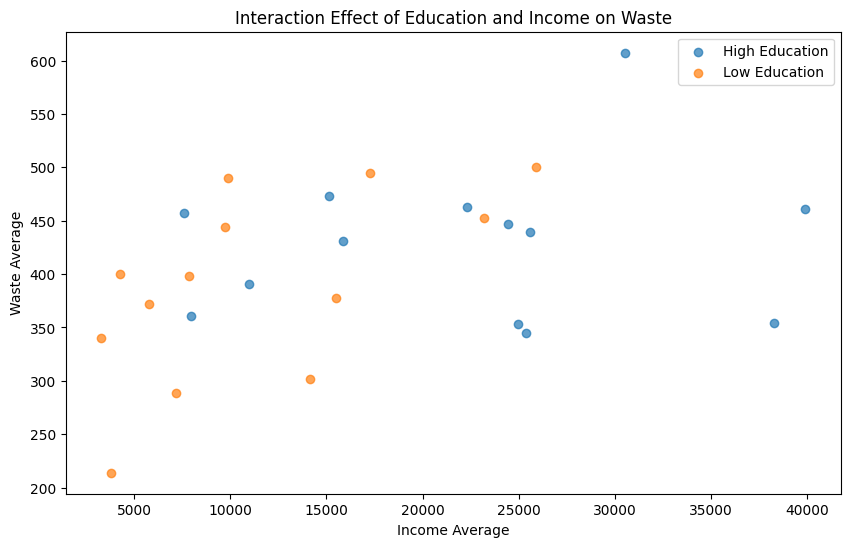

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Plot interaction effect
plt.figure(figsize=(10, 6))

# Group data by education level (e.g., high and low) for visualization
high_education = merged_data[merged_data['Average_Education_Level'] > merged_data['Average_Education_Level'].median()]
low_education = merged_data[merged_data['Average_Education_Level'] <= merged_data['Average_Education_Level'].median()]

# Scatter plot for high education
plt.scatter(high_education['Income Average'], high_education['Waste Average'], label='High Education', alpha=0.7)
# Scatter plot for low education
plt.scatter(low_education['Income Average'], low_education['Waste Average'], label='Low Education', alpha=0.7)

# Add labels and legend
plt.xlabel('Income Average')
plt.ylabel('Waste Average')
plt.title('Interaction Effect of Education and Income on Waste')
plt.legend()
plt.show()


In [12]:
# Fit the regression model with the interaction term
refined_model = sm.OLS(Y, X).fit(cov_type='HC3') #with robust standard errors

# Print the summary of the refined regression model
print(refined_model.summary())


                            OLS Regression Results                            
Dep. Variable:          Waste Average   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     4.313
Date:                Tue, 26 Nov 2024   Prob (F-statistic):             0.0155
Time:                        14:48:29   Log-Likelihood:                -142.72
No. Observations:                  26   AIC:                             293.4
Df Residuals:                      22   BIC:                             298.5
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [15]:
df_urban_rural = pd.read_csv('urban-and-rural-population.csv')

In [17]:
display(df_urban_rural)

,Entity,Code,Year,Urban population,Rural population
0,Afghanistan,AFG,1960,724373,7898093
1,Afghanistan,AFG,1961,763336,8026804
2,Afghanistan,AFG,1962,805062,8163985
3,Afghanistan,AFG,1963,849446,8308019
4,Afghanistan,AFG,1964,896820,8458694
...,...,...,...,...,...
14392,Zimbabwe,ZWE,2018,4848158,10204026
14393,Zimbabwe,ZWE,2019,4945719,10408889
14394,Zimbabwe,ZWE,2020,5052214,10617452
14395,Zimbabwe,ZWE,2021,5166388,10827136


In [34]:
df_urban_rural['Entity'] = df_urban_rural['Entity'].replace('Turkey', 'Türkiye')

In [35]:
filtered_df = df_urban_rural[df_urban_rural['Entity'].isin(common_countries)]

In [36]:
filtered_df = filtered_df[(filtered_df['Year'] >= 2014) & (filtered_df['Year'] <= 2022)]

In [44]:
print(filtered_df.head(20))

        Entity Code  Year  Urban population  Rural population
747    Austria  AUT  2014           4916377           3629979
748    Austria  AUT  2015           4988134           3654565
749    Austria  AUT  2016           5058968           3677700
750    Austria  AUT  2017           5110858           3686708
751    Austria  AUT  2018           5153759           3686762
752    Austria  AUT  2019           5196085           3683835
753    Austria  AUT  2020           5238479           3678385
754    Austria  AUT  2021           5283472           3672325
755    Austria  AUT  2022           5357839           3684012
1188   Belgium  BEL  2014          10966157            242900
1189   Belgium  BEL  2015          11034732            239464
1190   Belgium  BEL  2016          11095615            235807
1191   Belgium  BEL  2017          11143219            231939
1192   Belgium  BEL  2018          11198627            228427
1193   Belgium  BEL  2019          11263911            225069
1194   B

In [38]:
num_countries = filtered_df['Entity'].nunique()
print(f"There are {num_countries} different countries in the dataset.")

There are 26 different countries in the dataset.


In [39]:
averaged_df = filtered_df.groupby('Entity')[['Urban population', 'Rural population']].mean().reset_index()

In [40]:
veraged_df = filtered_df.groupby('Entity')[['Urban population', 'Rural population']].mean().reset_index()

# Display the result (optional):
from IPython.display import display
display(averaged_df)

,Entity,Urban population,Rural population
0,Austria,5.144886e+06,3.672697e+06
1,Belgium,1.120636e+07,2.288076e+05
2,Bulgaria,5.239141e+06,1.747898e+06
3,Cyprus,8.137809e+05,4.030590e+05
4,Czechia,7.826893e+06,2.774187e+06
5,Denmark,5.079662e+06,7.002464e+05
6,Estonia,9.127552e+05,4.118331e+05
7,Finland,4.707461e+06,8.045787e+05
8,France,5.402446e+07,1.312615e+07
9,Germany,6.393431e+07,1.871330e+07


In [43]:
def format_number(x):
  if isinstance(x, (int, float)):
    return "{:,.0f}".format(x).replace(',', "'")
  return x

formatted_df = averaged_df.applymap(format_number)

# Optional: Display the formatted DataFrame to verify the change
from IPython.display import display
display(formatted_df)

<ipython-input-43-34f91dbd68e8>:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_df = averaged_df.applymap(format_number)


,Entity,Urban population,Rural population
0,Austria,5'144'886,3'672'697
1,Belgium,11'206'357,228'808
2,Bulgaria,5'239'141,1'747'898
3,Cyprus,813'781,403'059
4,Czechia,7'826'893,2'774'187
5,Denmark,5'079'662,700'246
6,Estonia,912'755,411'833
7,Finland,4'707'461,804'579
8,France,54'024'462,13'126'153
9,Germany,63'934'307,18'713'300
